In [175]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import copy
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        #alina smoothed stuff lives here
        self.accel_smoothed = copy.deepcopy(self.accel);
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        #alina smoothed stuff lives here
        
        self.gyro = SensorData("Accelerometer", *parsedGyroLogData[1:])
        self.gyro_smoothed = copy.deepcopy(self.gyro);
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [176]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(logPath, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(logPath, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

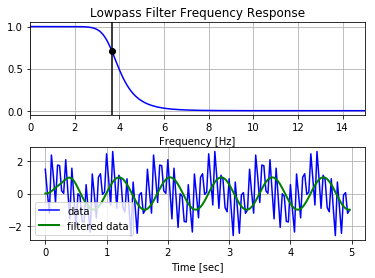

In [177]:
# from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
# LowPassFilter
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()


In [178]:
def shift_to_common(arrayToShift, truth):
    
    correlateAToB = signal.correlate(arrayToShift, truth)
    bestCorrelationPoint = np.argmax(correlateAToB)
    indexShift = len(arrayToShift) - bestCorrelationPoint
    result = np.roll(arrayToShift, indexShift)
    return result;


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


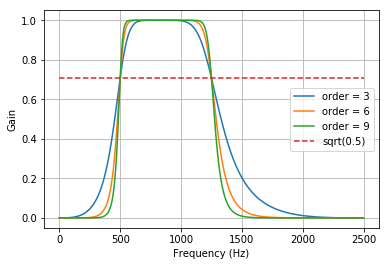

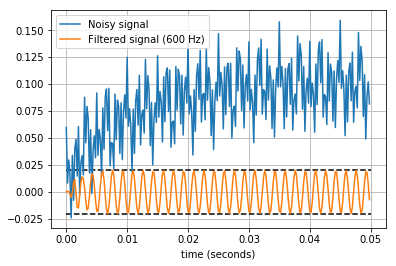

In [179]:
# band filter
# from http://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass

from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()

In [180]:
# Load the data

# You should change the path to the location of the log files on your system
# logPath = '/Users/jonf/Dropbox/CSE590_UbiComp/Git/CSE590Sp2018p/A02-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\CSE590_UbiComp\Git\CSE590Sp2018\A02-GestureRecognizer\JonGestureLogs"
logPath = '/Users/algendel/Desktop/__School/Projects/CSEP590/anaconda/A02-GestureRecognizer/JonGestureLogs'
#logPath = '/Users/algendel/Desktop/__School/Projects/CSEP590/anaconda/A02-GestureRecognizer/AlinaGestureLogs'
mapGestureToTrials = parse_and_create_gesture_trials(logPath)
#mapGestureToTrialsAlina = parse_and_create_gesture_trials(logPathAlina)

Found 100 csv files in /Users/algendel/Desktop/__School/Projects/CSEP590/anaconda/A02-GestureRecognizer/JonGestureLogs
Found 10 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match


In [181]:
#Alina let's correlate the signals
def correlate():
    index = 0
    xyz = ['x', 'y', 'z', 'mag']
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            for axis in xyz:
                oldVal = getattr(trial.accel, axis);
                truth = getattr(gestureTrials[0].accel, axis)
                newVal = shift_to_common(oldVal, truth)
                setattr(trial.accel_smoothed, axis, newVal)
                oldVal = getattr(trial.gyro, axis);
                truth = getattr(gestureTrials[0].gyro, axis)
                newVal = shift_to_common(oldVal, truth)
                setattr(trial.gyro_smoothed, axis, newVal)

            trialNum = trialNum + 1

        index = index + 1


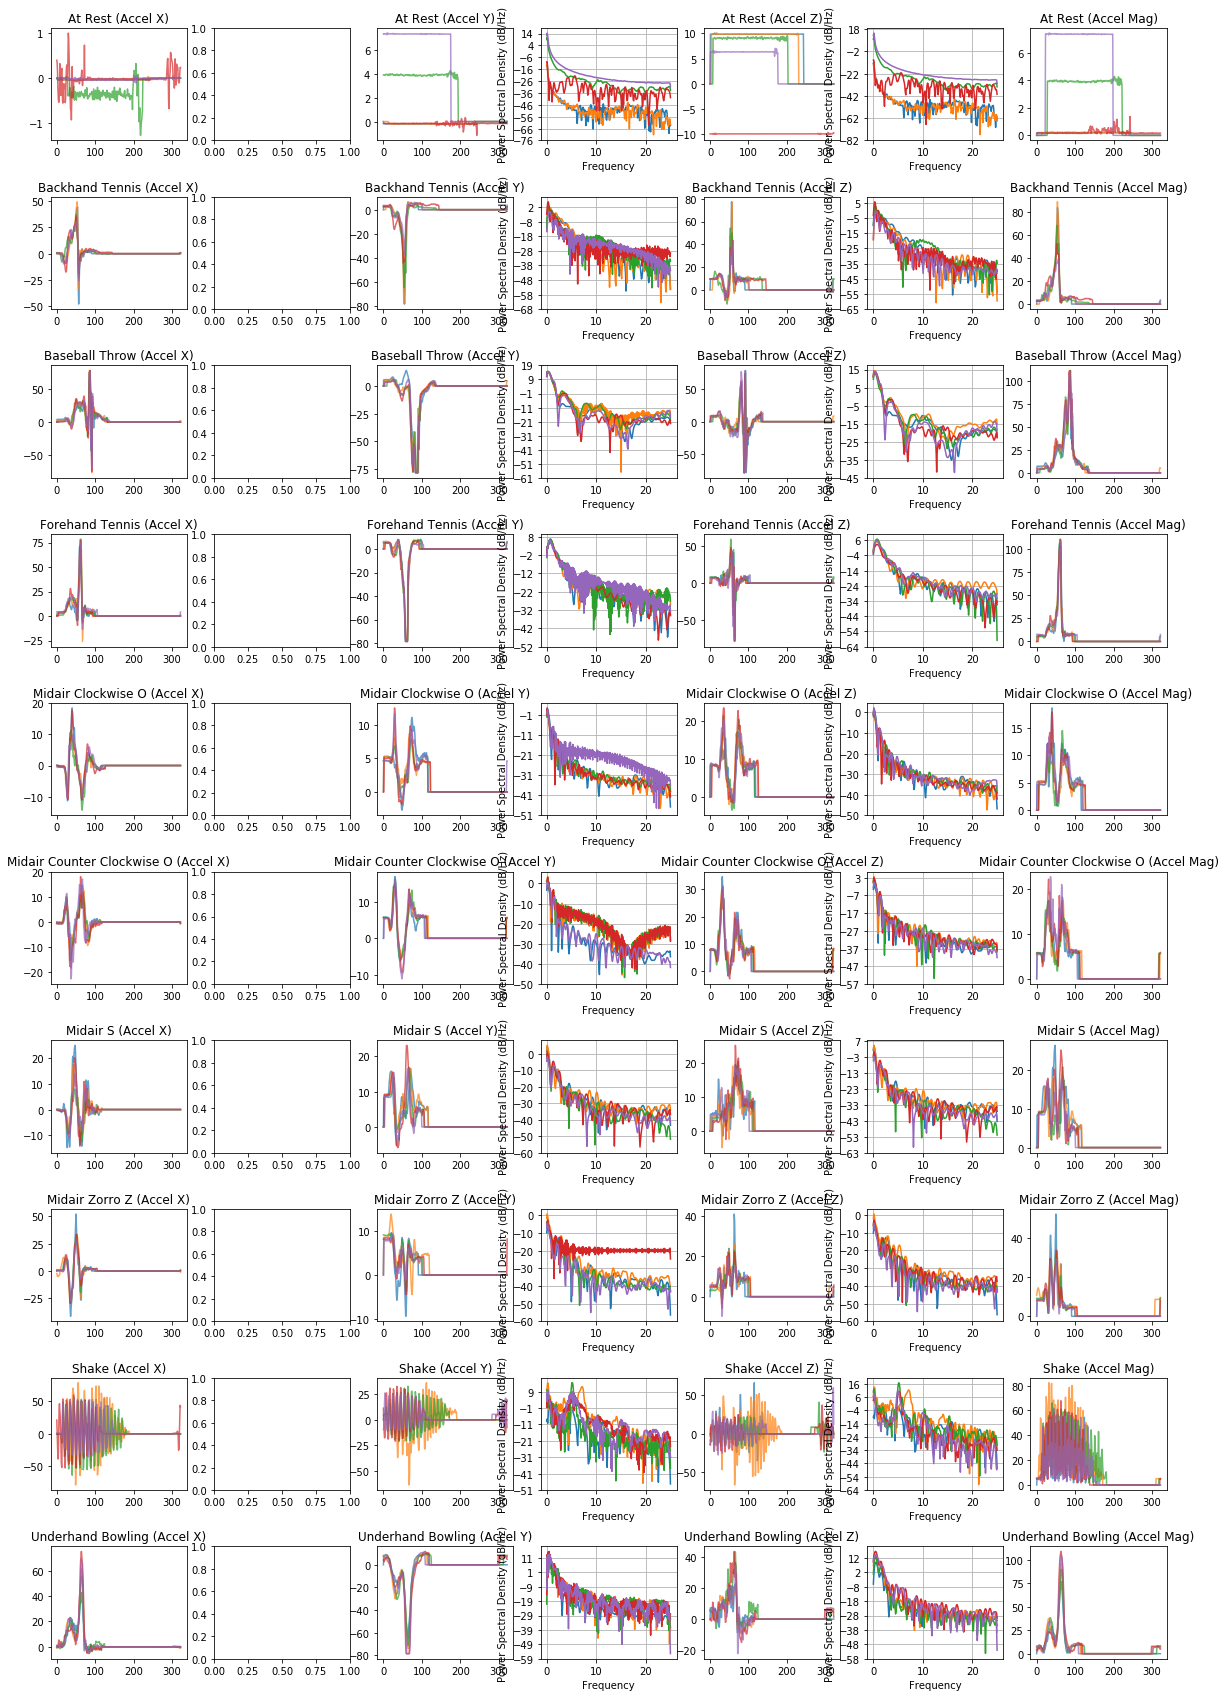

In [182]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)

fig, axes = plt.subplots(len(mapGestureToTrials), 7, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)
correlate()
index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel_smoothed.x, alpha=0.7, label="Trial {}".format(trialNum)) #trialNum
        #y = butter_lowpass_filter(trial.accel.x, 3.16, 50, 6)
        #axes[index][1].psd(y, NFFT=512, Fs=50)
        axes[index][2].plot(trial.accel_smoothed.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].psd(trial.accel_smoothed.y,  NFFT=512, Fs=50)
        axes[index][4].plot(trial.accel_smoothed.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][5].psd(trial.accel.y,  NFFT=512, Fs=50)
        axes[index][6].plot(trial.accel_smoothed.mag, alpha=0.7, label="Trial {}".format(trialNum))
      
        #plt.specgram(trial.accel.mag, 256,64,0)
        #plt.show()
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    #axes[index][0].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Y)")
    #axes[index][2].legend()
    
    axes[index][4].set_title(gestureName + " (Accel Z)")
    #axes[index][4].legend()
    
    axes[index][6].set_title(gestureName + " (Accel Mag)")
    #axes[index][6].legend()
    index = index + 1
    






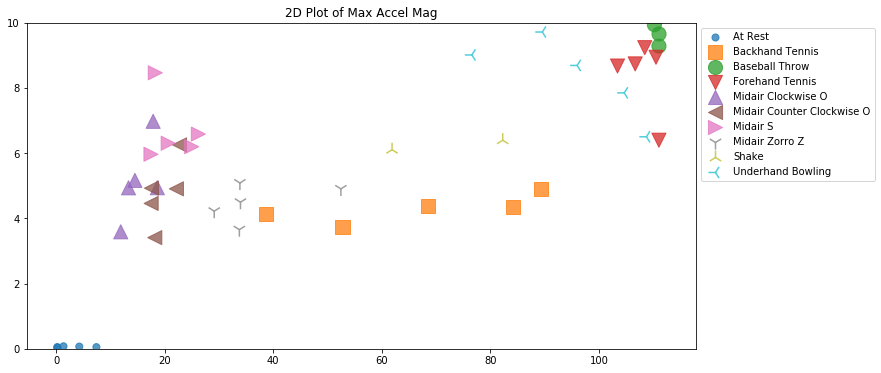

In [183]:
# Now explore the discriminability of 2 dimensions!
# For this exercise, you're going to explore these features in 2D by combining them. Please wait
# to complete this exercise until we get to it in class
# I purposefully did not give you skeleton code here. Please copy/paste a section from the above cell
# and adapt it to plot two features at a time in a scatter plot

from scipy import signal
import numpy as np



import itertools

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

#alina
#tollest z height
#standar diviation 
#number of peaks
#width of triangle bfalinaaase
#diff between min and max
#size of the base
#length of the signal
#max accel magnitude
#top 5 intensities


# Plots the maximum magnitude of each trial's acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    
    x = list(trial.accel.mag.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    
    #y_coordinates = np.array(y_coordinates) # convert your 1-D array to a numpy array if it's not, otherwise omit this line
    #peak_widths = np.arange(1, 4)
    #peak_indices = signal.find_peaks_cwt(trial.accel.mag, peak_widths)
    #peak_count = len(peak_indices) # the number of peaks in the array
    
    y = list((trial.gyro.mag.max()) for trial in trials)
    #y = list((peak_count) for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("2D Plot of Max Accel Mag")
plt.show()



In [184]:
#Alina: lets create the folds

from random import shuffle

def get_folds (mapGestureToTrials) :
    gestureNamesSorted = sorted(mapGestureToTrials.keys())

    folds = [list(), list(), list(), list(), list()]
    index = 0
    for gestureName in gestureNamesSorted:
        gestureTrials = copy.deepcopy(mapGestureToTrials[gestureName]);
        shuffle(gestureTrials)
        trialIndex = 0
        for trial in gestureTrials:
            folds[trialIndex].append(trial)
            trialIndex = trialIndex+1;

        index = index + 1

    index = 0
    # print the folds
  
    return folds

folds = get_folds(mapGestureToTrials)

In [185]:

# this is where we are going to store the results
# since all gestures are represented in fold - we'll just pass the first fold to id
def create_gesture_results_dictionary(fold):
    gestureDictionary = {}
    for gestureTrial in fold:
        #key is the name with _ instead of spaces
        gestureDictionary[gestureTrial.gestureName.replace(" ", "_")] = {"gname": gestureTrial.gestureName, "matches": list()}
    return gestureDictionary

In [187]:
# Now, let's try to build an SVM using some of the features you brainstormed. 
# We're going to start with the simplest possible SVM using only one feature
# 
# Some nice resources:
#  - Official sci-kit learn (Start here!): http://scikit-learn.org/stable/modules/svm.html
#  - A simple classification example using scikit: https://dbaumgartel.wordpress.com/2014/03/10/a-scikit-learn-example-in-10-lines/
#  - A nice video overview of SVM: https://youtu.be/N1vOgolbjSc
#  
#
from sklearn import svm

numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(mapGestureToTrials)
#foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials)

folds = get_folds(mapGestureToTrials)

#print(foldToMapGestureToTrial)
    
gestureNames = list(mapGestureToTrials.keys())

# now build an SVM
# Currently training on folds 1-4 and testing on fold 0 (just for now)
foldIndex = 0
mapGestureNameToCorrectMatchCnt = dict()
mapGestureNameToPredictionResultList = dict()

def train_it(foldList):
    classLabels = np.array([])
    i2 = 0
    for fold in foldList:
        # print("\tFold: ", i)
        #fold = foldToMapGestureToTrial[i]

        #for gestureName, trial in fold.items():
        for trial in fold:
            if i2==0:
                trainingData = [[trial.accel.mag.max(), trial.accel.mag.std()]]
            else:
                trainingData = np.append(trainingData, [[trial.accel.mag.max(), trial.accel.mag.std()]], axis = 0)
            classLabels = np.append(classLabels, trial.gestureName)
            i2 = i2+1


    #for row in range(0,len(classLabels)):
        #print("gestureName={} values={}".format(classLabels[row], trainingData[row]))
    return trainingData,  classLabels
        
# Setup SVM
#trainingData = trainingData.reshape(-1, 1) # for 1D input feature vectors, we have to reshape like this

# Traing our SVM
#print(trainingData)
 
def find_ml(trial, trainFolds):
    data, labels = train_it(trainFolds)

    clf = svm.SVC()
    clf.fit(data, labels)

    # Test our SVM
    # fold 0 will be our test fold
 
    print("Attempting to predict: {}".format(trial.gestureName))
    svmPrediction = clf.predict([[trial.accel.mag.max(),trial.accel.mag.std()]])
    print("SVM prediction: {}".format(svmPrediction[0]))
    return svmPrediction[0]
    #for trial in testFold:
        #print("Attempting to predict: {}".format(trial.gestureName))
        #svmPrediction = clf.predict([[trial.accel.mag.max(),trial.accel.mag.std()]])
        #print("SVM prediction: {}".format(svmPrediction[0]))
    

In [ ]:
#This is where we find the closest gesture

from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

# This finds the closest in each individual fold. This is not implementation that is required but I am leaving it in 
# in case I'm wrong
def find_closest_old (source, foldsList):
    lst = [None] * len(foldsList)
    
    closest = 10000000
    index = 0
    trial_ = ""
    distance = 100000
    for fold in foldsList:
        #print("doing fold {}".format(index)); 
        closest = 10000000
        trial_ = ""
        distance = 100000
        for trial in fold:

            distance, path = fastdtw(trial.accel_smoothed.mag, source.accel_smoothed.mag)
            if distance < closest:
                closest = distance
                trial_ = trial.gestureName
                lst[index] = trial.gestureName      
        #print("closest to {} is {} with distance {}".format(source.gestureName, trial_, distance ))
        index = index + 1
     
    return lst


def find_closest (source, foldsList):
    lst = [None] * len(foldsList)
    
    closest = 10000000
    index = 0
    trial_ = ""
    distance = 100000
    trial_ = ""
    winning_fold_index = -1
    print("---------------------------------------------------------")
    print("Finding matches for {}".format(source.gestureName))
    for fold in foldsList:
        #print("doing fold {}".format(index)); 
        for trial in fold:
            distance, path = fastdtw(trial.accel_smoothed.x, source.accel_smoothed.x)
            if distance < closest:
                closest = distance
                trial_ = trial.gestureName
                lst[index] = trial.gestureName 
                winning_fold_index = index
                print("updated closest to {} with distance {} from fold {}".format(trial.gestureName, distance, index ))
        index = index + 1
    print("for {} winner is {} from {}".format(source.gestureName, trial_, winning_fold_index))
    return trial_

In [188]:
#this is our runner that will populate the results
def run_me(testFold, templateFolds, index, results_dictionary, _type):
    for gestureTrial in testFold:
        currentGestureName = gestureTrial.gestureName
        currentResultsKey = currentGestureName.replace(" ", "_")
        #print(currentResultsKey)
        if(_type == 0):
            result = find_closest (gestureTrial, templateFolds)
        else:
            result= find_ml(gestureTrial, templateFolds)
        #print("For fold {} for gesture {} we have a result{}".format(index, currentGestureName, result))
        dictionaryEntry = results_dictionary[currentResultsKey]
        #print(result)
        #print(dictionaryEntry)
        dictionaryEntry["matches"].append(result);
        
    return results_dictionary
    
folds = get_folds(mapGestureToTrials)
gesturesMap = {}



results_dictionary = create_gesture_results_dictionary(folds[0])


index = 0

for testFold in folds:
    #testFold = folds[0]
    if 4>index > 1:
        #templateFolds = folds[1:]
        templateFolds = folds[0:index]+folds[index+1:]
    elif index == 4:
        templateFolds = folds[0:4]
    else:
        templateFolds = folds[1:]
        
    run_me(testFold, templateFolds, index, results_dictionary, 1)
    
    index = index + 1

print(results_dictionary)

#now let's process our results




Attempting to predict: At Rest
SVM prediction: Underhand Bowling
Attempting to predict: Backhand Tennis
SVM prediction: Midair Zorro Z
Attempting to predict: Baseball Throw
SVM prediction: Baseball Throw
Attempting to predict: Forehand Tennis
SVM prediction: Forehand Tennis
Attempting to predict: Midair Clockwise O
SVM prediction: Midair Clockwise O
Attempting to predict: Midair Counter Clockwise O
SVM prediction: Midair Counter Clockwise O
Attempting to predict: Midair S
SVM prediction: Underhand Bowling
Attempting to predict: Midair Zorro Z
SVM prediction: Midair Zorro Z
Attempting to predict: Shake
SVM prediction: Underhand Bowling
Attempting to predict: Underhand Bowling
SVM prediction: Underhand Bowling
Attempting to predict: At Rest
SVM prediction: At Rest
Attempting to predict: Backhand Tennis
SVM prediction: Backhand Tennis
Attempting to predict: Baseball Throw
SVM prediction: Baseball Throw
Attempting to predict: Forehand Tennis
SVM prediction: Forehand Tennis
Attempting to pr

In [189]:
def get_correct_answers(key):
    item = results_dictionary[key]
    correctAnswers = len(list(filter(lambda x: x == item["gname"], item["matches"])))
    return correctAnswers



print("============= AND NOW FOR THE RESULTS =====================")
result = 0
total_gestures = len(folds)*len(folds[0])

for key in results_dictionary:
    result = result + get_correct_answers(key);


print("Using DTW with previously correlated graphs the Accuracy is {}/{} {}%".format(result, total_gestures, result/total_gestures*100))

for key in results_dictionary:
    correctAnswers = get_correct_answers(key)
    print("{} {}/{} {}%".format(results_dictionary[key]["gname"], correctAnswers, len(folds), correctAnswers/len(folds)* 100))


============= AND NOW FOR THE RESULTS =====================
Using DTW with previously correlated graphs the Accuracy is 33/50 66.0%
At Rest 3/5 60.0%
Backhand Tennis 1/5 20.0%
Baseball Throw 5/5 100.0%
Forehand Tennis 4/5 80.0%
Midair Clockwise O 4/5 80.0%
Midair Counter Clockwise O 4/5 80.0%
Midair S 3/5 60.0%
Midair Zorro Z 4/5 80.0%
Shake 3/5 60.0%
Underhand Bowling 2/5 40.0%
